In [1]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2050'

In [2]:
print(torch.__version__)

2.5.1+cu124


In [3]:
import os

data_dir = './animefacedataset'
print(os.listdir(data_dir))
print(os.listdir(data_dir+'/images')[:5])

['images']
['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg']


In [4]:
from torch.utils.data import DataLoader
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder 

In [5]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [6]:
train_ds = ImageFolder(data_dir,transform=tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    tf.ToTensor(),
    tf.Normalize(*stats)]))

train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def denom(image_tensor):
    return image_tensor * stats[1][0] + stats[0][0]

In [9]:
def show_images(images,nmax = 64):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denom(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl,nmax= 64):
    for images,_ in dl:
        show_images(images,nmax)
        break

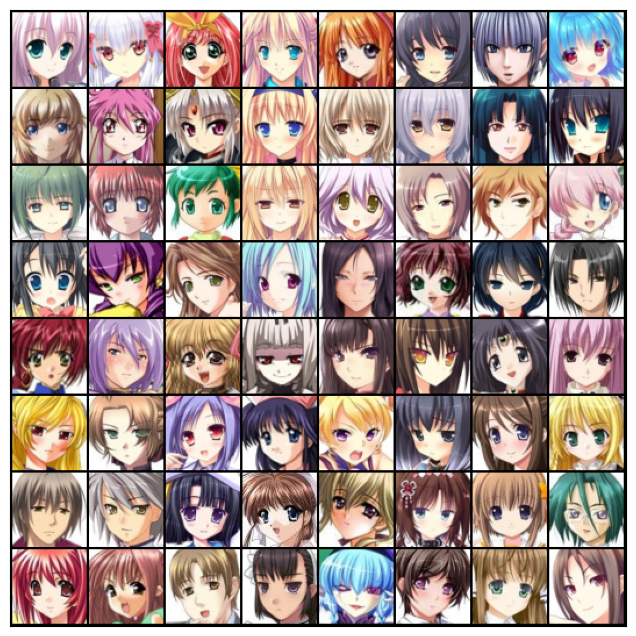

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking=True)
    
        
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl,device)

In [14]:
import torch.nn as nn

In [15]:
discriminator = nn.Sequential(
    #3 x 64 x 64

     nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1, bias=False),
     nn.BatchNorm2d(64),
     nn.LeakyReLU(0.2,inplace=True),

     #out 64 x 32 x 32

     nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1, bias=False),
     nn.BatchNorm2d(128),
     nn.LeakyReLU(0.2,inplace=True),

     #out 128 x 16 x 16

     nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1, bias=False),
     nn.BatchNorm2d(256),
     nn.LeakyReLU(0.2,inplace=True),
 
     #out 256 x 8 x 8

     nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1, bias=False),
     nn.BatchNorm2d(512),
     nn.LeakyReLU(0.2,inplace=True),

     #out 512 x 4 x 4

     nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0, bias=False),

     #out 1 x 1 x 1

     nn.Flatten(),
     nn.Sigmoid())

In [16]:
discriminator = to_device(discriminator,device)

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    #in = latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out = 512 x 4 x 4

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out = 256 x 8 x 8

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out = 128 x 16 x 16

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out = 64 x 32 x 32

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    #out = 3 x 64 x 64

)

torch.Size([128, 3, 64, 64])


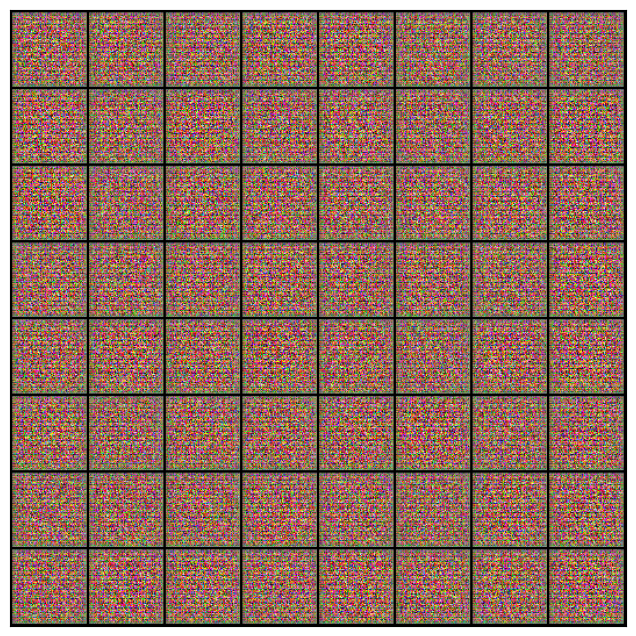

In [19]:
xb = torch.randn(batch_size,latent_size,1,1) #random latent tensors

fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator,device)

In [21]:
import torch.nn.functional as F

In [22]:
def train_discriminator(real_images,opt_d):

    #Clear discriminator gradients
    opt_d.zero_grad()

    #Pass real image through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()

    #Generate fake images
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    #Update discriminator weight
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score




In [23]:
def train_generator(opt_g):

    #Clear generator gradients
    opt_g.zero_grad()

    #Generate fake images
    latent  = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)

    #try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds,targets)

    #update generator weights
    loss.backward()
    opt_g.step()
    return loss.item()

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated_anime'
os.makedirs(sample_dir,exist_ok=True)

In [26]:
def save_samples(index,latent_tensors,show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denom(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
    print('saving', fake_fname)
    if show:
        fig,ax = plt.subplots(figsize = (8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [27]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99990827..0.9999647].


saving generated-images-0000.png


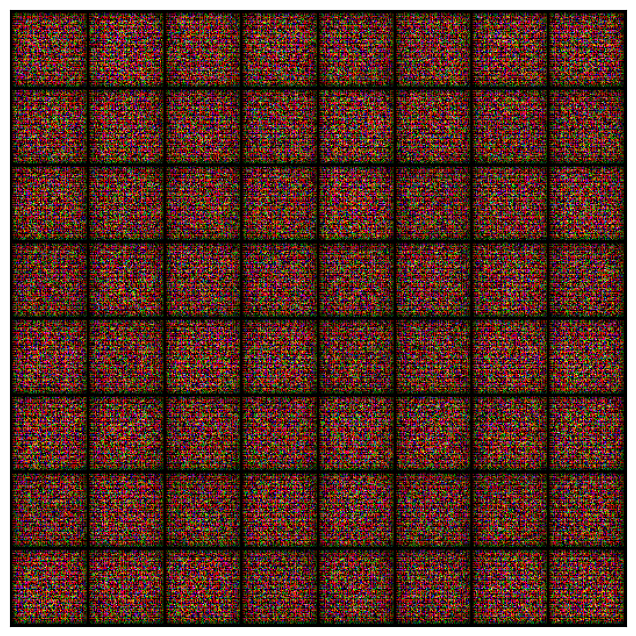

In [28]:
save_samples(0,fixed_latent)

In [29]:
def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr, betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in train_dl:

            loss_d, real_score, fake_score = train_discriminator(real_images,opt_d)
            loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f},loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format
              (epoch+1,epochs,loss_g,loss_d,real_score,fake_score))
        
        save_samples(epoch+start_idx, fixed_latent,show=False)

    return losses_g,losses_d, fake_scores,real_scores

In [31]:
lr= 0.0002

epochs = 8

In [32]:
history = fit(epochs,lr)

Epoch [1/8], loss_g: 2.6427,loss_d: 0.2243, real_score: 0.8491, fake_score: 0.0311
saving generated-images-0001.png
Epoch [2/8], loss_g: 8.6264,loss_d: 1.1118, real_score: 0.9120, fake_score: 0.5735
saving generated-images-0002.png
Epoch [3/8], loss_g: 5.7951,loss_d: 0.3096, real_score: 0.9454, fake_score: 0.2091
saving generated-images-0003.png
Epoch [4/8], loss_g: 4.8973,loss_d: 0.3559, real_score: 0.7698, fake_score: 0.0199
saving generated-images-0004.png
Epoch [5/8], loss_g: 5.2262,loss_d: 0.2349, real_score: 0.9115, fake_score: 0.1185
saving generated-images-0005.png
Epoch [6/8], loss_g: 5.9071,loss_d: 0.2814, real_score: 0.8075, fake_score: 0.0033
saving generated-images-0006.png
Epoch [7/8], loss_g: 6.8861,loss_d: 0.1281, real_score: 0.9923, fake_score: 0.1074
saving generated-images-0007.png
Epoch [8/8], loss_g: 12.4753,loss_d: 0.4544, real_score: 0.9826, fake_score: 0.3250
saving generated-images-0008.png
